In [1]:
import polars as pl
import numpy as np

from data_valuation.core.loo_valuator import LOOValuator
from data_valuation.core.shapley_valuator import ShapleyValuator
from data_valuation.core.dvrl_valuator import DVRLValuator
from data_valuation.utils.data_utils import get_min_max_scores

/Users/takumishibata/Documents/project/data-valuation/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1. Load ASAP dataset

In [2]:
def scale_score(score: int, essay_set: int, score_dict: dict) -> float:
    minscore, maxscore = score_dict[essay_set]['score']
    return (score - minscore) / (maxscore - minscore)

In [3]:
PROMPT_ID = 4
RAMDOM_SEED = 42

asap_data = pl.read_excel('training_set_rel3.xlsx', infer_schema_length=15000)
asap_data = asap_data.drop_nulls("domain1_score")
asap_data = asap_data.select(['essay_id', 'essay_set', 'essay', 'domain1_score'])
asap_data = asap_data.with_columns(
    pl.struct(['domain1_score', 'essay_set'])
    .map_elements(lambda x: scale_score(x['domain1_score'], x['essay_set'], get_min_max_scores()), return_dtype=pl.Float64)
    .alias('scaled_score')
)
asap_data = asap_data.filter(pl.col('essay_set') == PROMPT_ID)
asap_data

essay_id,essay_set,essay,domain1_score,scaled_score
i64,i64,str,i64,f64
8863,4,"""The author concludes the story…",0,0.0
8864,4,"""The narrater has that in with …",0,0.0
8865,4,"""The author concludes the story…",3,1.0
8866,4,"""The author ended the story wit…",2,0.666667
8867,4,"""The author concludes the story…",2,0.666667
…,…,…,…,…
10638,4,"""To me it seam like the whoever…",0,0.0
10639,4,"""The author concludes the story…",2,0.666667
10640,4,"""The author uses this conclusio…",1,0.333333


In [4]:
from sklearn.model_selection import train_test_split

train_data, temp_data = train_test_split(asap_data, train_size=0.6, random_state=RAMDOM_SEED)
dev_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=RAMDOM_SEED)

print(f"Train data size: {train_data.shape}")
print(f"Dev data size: {dev_data.shape}")
print(f"Test data size: {test_data.shape}")

Train data size: (1062, 5)
Dev data size: (354, 5)
Test data size: (355, 5)


# Step 2. Add noise

In [5]:
def add_noise(data: pl.DataFrame, noise_ratio: float, noise_range: tuple, seed: int) -> pl.DataFrame:
    np.random.seed(seed)
    noise_indices = np.random.choice(data.shape[0], int(data.shape[0] * noise_ratio), replace=False)
    noise_signs = np.random.choice([-1, 1], len(noise_indices))
    noise = np.random.uniform(noise_range[0], noise_range[1], len(noise_indices))

    noisy_scores = data['scaled_score'].to_numpy().copy()
    noisy_scores[noise_indices] += noise_signs * noise
    noisy_scores = np.clip(noisy_scores, 0, 1)  # Clipping

    data = data.with_columns(pl.Series(noisy_scores).alias('noisy_score'))

    is_noisy = np.zeros(data.shape[0], dtype=bool)
    is_noisy[noise_indices] = True
    data = data.with_columns(pl.Series(is_noisy).alias('is_noisy'))
    return data

train_data = add_noise(train_data, noise_ratio=0.2, noise_range=(0.4, 0.6), seed=RAMDOM_SEED)
train_data

essay_id,essay_set,essay,domain1_score,scaled_score,noisy_score,is_noisy
i64,i64,str,i64,f64,f64,bool
10325,4,"""In the Story the @CAPS1 conclu…",2,0.666667,0.666667,false
9587,4,"""The author concludes the story…",2,0.666667,0.666667,false
10086,4,"""The author includes the story …",1,0.333333,0.0,true
9854,4,"""The author concludes the story…",1,0.333333,0.841714,true
10138,4,"""The author concluded his stori…",0,0.0,0.0,false
…,…,…,…,…,…,…
9996,4,"""I think the author concludes t…",0,0.0,0.0,false
10162,4,"""I think the author conclades t…",2,0.666667,0.666667,false
9726,4,"""The author ends the story “Win…",2,0.666667,0.666667,false


# Step 3. Choose Valuation Type

In [13]:
# Leave-One-Out Valuation
valuator = LOOValuator(
    prompt_id=PROMPT_ID,
    device='cpu',
    seed=RAMDOM_SEED,
    # wandb_logging=True, # if you want to log the results to wandb
    # wandb_project='data-valuation-test', # if you want to log the results to wandb
    # wandb_name=f'LOO-Noise-Detection-Prompt-{PROMPT_ID}', # if you want to log the results to wandb
    # embedding_model='microsoft/deberta-v3-large',
    embedding_model='bert-base-uncased',
)


=== LOOValuator Hyperparameters ===
Prompt ID: 3
Device: cpu
Seed: 42
Metric: mse
Embedding Model: bert-base-uncased
Max Length: 512
Pooling Strategy: cls
Batch Size: 512
Epochs: 100
Model Type: mlp
Learning Rate: 0.001



In [14]:
# Data Shapley Valuation
valuator = ShapleyValuator(
    prompt_id=PROMPT_ID,
    device='cpu',
    seed=RAMDOM_SEED,
    # wandb_logging=True,
    # wandb_project='data-valuation-test',
    # wandb_name=f'Shapley-Noise-Detection-Prompt-{PROMPT_ID}',
    embedding_model='bert-base-uncased',
)


=== ShapleyValuator Hyperparameters ===
Prompt ID: 3
Device: cpu
Seed: 42
Metric: mse
Embedding Model: bert-base-uncased
Max Length: 512
Pooling Strategy: cls
Max Iterations: 5000
Threshold: 0.05
Model Type: mlp
Learning Rate: 0.001



In [6]:
# Data Valuation with Reinforcement Learning (DVRL)
valuator = DVRLValuator(
    prompt_id=PROMPT_ID,
    device='cpu',
    seed=RAMDOM_SEED,
    # wandb_logging=True,
    # wandb_project='data-valuation-test',
    # wandb_name=f'DVRL-Noise-Detection-Prompt-{PROMPT_ID}',
    embedding_model='bert-base-uncased',
)


=== DVRLValuator Hyperparameters ===
Prompt ID: 4
Device: cpu
Seed: 42
Metric: qwk
Embedding Model: bert-base-uncased
Max Length: 512
Pooling Strategy: cls
Hidden Dimension: 100
Combination Dimension: 10
Iterations: 1000
Inner Iterations: 100
Batch Size: 10000
Learning Rate: 0.001
Predictor Batch Size: 512
Model Type: mlp
Epsilon: 1e-08
Threshold: 0.9



# Step 4. Estimate Data Values

In [7]:
estimated_values = valuator.estimate_values(
    x_train=train_data['essay'].to_list(),
    y_train=train_data['noisy_score'].to_numpy(),
    x_val=dev_data['essay'].to_list(),
    y_val=dev_data['scaled_score'].to_numpy(),
    sample_ids=train_data['essay_id'].to_numpy(),
)

# Save the estimated values
valuator.save_values(estimated_values, f'./output_files/estimated_values_{PROMPT_ID}.csv')

Training DVRL: 100%|██████████| 1000/1000 [21:23<00:00,  1.28s/it]

Values saved to ./output_files/estimated_values_4.csv


# Step 5. Discover corrupted sample

In [6]:
# Load the estimated values as DataFrame
value_df = pl.read_csv(f'./output_files/estimated_values_{PROMPT_ID}.csv').rename({'sample_id': 'essay_id'})
train_data = train_data.join(value_df, on='essay_id', how='left')
train_data

essay_id,essay_set,essay,domain1_score,scaled_score,noisy_score,is_noisy,value
i64,i64,str,i64,f64,f64,bool,f64
10325,4,"""In the Story the @CAPS1 conclu…",2,0.666667,0.666667,false,0.541004
9587,4,"""The author concludes the story…",2,0.666667,0.666667,false,0.53248
10086,4,"""The author includes the story …",1,0.333333,0.0,true,0.529481
9854,4,"""The author concludes the story…",1,0.333333,0.841714,true,0.517336
10138,4,"""The author concluded his stori…",0,0.0,0.0,false,0.539267
…,…,…,…,…,…,…,…
9996,4,"""I think the author concludes t…",0,0.0,0.0,false,0.538608
10162,4,"""I think the author conclades t…",2,0.666667,0.666667,false,0.535974
9726,4,"""The author ends the story “Win…",2,0.666667,0.666667,false,0.541268


array([0.19339623, 0.37735849, 0.51415094, 0.60849057, 0.65566038,
       0.68396226, 0.69811321, 0.75      , 0.78301887, 0.8254717 ,
       0.84433962, 0.86320755, 0.87735849, 0.88207547, 0.9009434 ,
       0.93396226, 0.97169811, 0.98584906, 1.        , 1.        ])

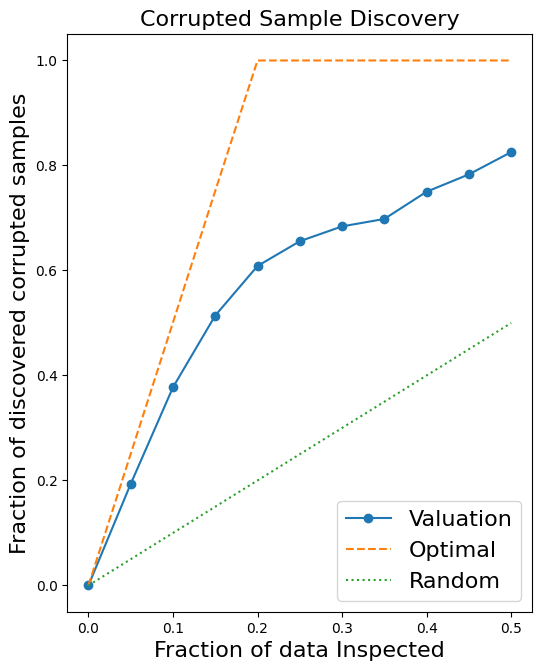

In [7]:
import matplotlib.pyplot as plt

def discover_corrupted_sample(dve_out, noise_mask, noise_rate, output_path=None, plot=True):
  """Reports True Positive Rate (TPR) of corrupted label discovery.

  Args:
    dve_out: data values (numpy array)
    noise_mask: 各サンプルがノイズか否かを示す True/False のブール配列
    noise_rate: ノイズサンプルの割合
    output_path: プロット画像の出力先パス
    plot: プロットを表示するかどうか

  Returns:
    output_perf: パーセンタイル毎（例: 5%刻み）に算出したノイズ検出率（TPR）
  """

  # サンプルをデータ値でソート
  num_bins = 20  # 100%を20分割
  sort_idx = np.argsort(dve_out)

  # 出力用初期化
  output_perf = np.zeros([num_bins,])
  total_noise = np.sum(noise_mask)  # 全ノイズサンプル数

  # 各パーセンタイルごとに計算
  for itt in range(num_bins):
    num_samples = int((itt+1) * len(dve_out) / num_bins)
    # 現在の範囲内でのノイズサンプル数をカウント
    discovered_noise = np.sum(noise_mask[sort_idx[:num_samples]])
    output_perf[itt] = discovered_noise / total_noise

  # ノイズ検出率のグラフをプロット
  if plot:
    num_x = int(num_bins / 2 + 1)
    x = [a * (1.0 / num_bins) for a in range(num_x)]
    y_dvrl = np.concatenate((np.zeros(1), output_perf[:(num_x - 1)]))
    y_opt = [min(a * ((1.0 / num_bins) / noise_rate), 1) for a in range(num_x)]
    y_random = x

    plt.figure(figsize=(6, 7.5))
    plt.plot(x, y_dvrl, 'o-')
    plt.plot(x, y_opt, '--')
    plt.plot(x, y_random, ':')
    plt.xlabel('Fraction of data Inspected', size=16)
    plt.ylabel('Fraction of discovered corrupted samples', size=16)
    plt.legend(['Valuation', 'Optimal', 'Random'], prop={'size': 16})
    plt.title('Corrupted Sample Discovery', size=16)
    if output_path:
        plt.savefig(output_path + 'corrupted_sample_discovery.png')

  # ノイズ検出率 (TPR) を返す
  return output_perf

# Assuming 'value' column contains the data values
dve_out = train_data['value'].to_numpy()
# Assuming 'is_noisy' column indicates corrupted samples (True for corrupted)
noise_mask = train_data['is_noisy'].to_numpy()
noise_rate = train_data['is_noisy'].mean()  # Calculate the noise rate

# Call the function and plot
discover_corrupted_sample(dve_out, noise_mask, noise_rate)

# Step 6. Calculate F1 score

In [8]:
from sklearn.cluster import KMeans

# Extract the 'value' column for clustering
values = train_data['value'].to_numpy().reshape(-1, 1)

# Perform KMeans clustering with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
train_data = train_data.with_columns(pl.Series(kmeans.fit_predict(values)).alias("cluster"))

# Calculate the mean value for each cluster
cluster_means = train_data.group_by("cluster").agg([pl.mean("value").alias("mean_value")])

# Determine which cluster has higher mean value
high_value_cluster = cluster_means.filter(pl.col("mean_value") == cluster_means["mean_value"].max())["cluster"][0]

# Assign 'is_noisy_kmeans' based on cluster assignment: 
#  - False if in the cluster with higher mean value
#  - True otherwise
train_data = train_data.with_columns(
    (pl.col("cluster") != high_value_cluster).alias("is_noisy_kmeans")
)
train_data = train_data.drop("cluster")
train_data

essay_id,essay_set,essay,domain1_score,scaled_score,noisy_score,is_noisy,value,is_noisy_kmeans
i64,i64,str,i64,f64,f64,bool,f64,bool
10325,4,"""In the Story the @CAPS1 conclu…",2,0.666667,0.666667,false,0.541004,false
9587,4,"""The author concludes the story…",2,0.666667,0.666667,false,0.53248,true
10086,4,"""The author includes the story …",1,0.333333,0.0,true,0.529481,true
9854,4,"""The author concludes the story…",1,0.333333,0.841714,true,0.517336,true
10138,4,"""The author concluded his stori…",0,0.0,0.0,false,0.539267,false
…,…,…,…,…,…,…,…,…
9996,4,"""I think the author concludes t…",0,0.0,0.0,false,0.538608,false
10162,4,"""I think the author conclades t…",2,0.666667,0.666667,false,0.535974,false
9726,4,"""The author ends the story “Win…",2,0.666667,0.666667,false,0.541268,false


In [9]:
from sklearn.metrics import f1_score

# Calculate the F1 score between 'is_noisy' and 'is_noisy_kmeans'
f1 = f1_score(train_data['is_noisy'], train_data['is_noisy_kmeans'])

print(f"F1 Score: {f1}")

F1 Score: 0.5968109339407744


# Step 7. Fine-tuning BERT using only non-noisy data

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EvalPrediction
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, cohen_kappa_score
import polars as pl
import torch
from torch.utils.data import Dataset as TorchDataset # Rename to avoid conflict

# --- Configuration ---
# Specify the pre-trained model name. Can be changed to "roberta-base", "microsoft/deberta-base", etc.
model_name = "bert-base-uncased"
num_train_epochs = 2 # Number of training epochs (adjust as needed)
batch_size = 8 # Batch size per device (adjust based on GPU memory)
output_dir = "./bert_finetuned_non_noisy" # Directory to save model checkpoints and results
logging_dir = './logs_non_noisy' # Directory for logs
max_length = 512 # Max sequence length for tokenizer

# --- 1. Filter Non-Noisy Data ---
# Filter the training data to keep only the samples identified as non-noisy by KMeans
print(f"Original training data size: {len(train_data)}")
non_noisy_train_data = train_data.filter(pl.col("is_noisy_kmeans") == False)
print(f"Non-noisy training data size: {len(non_noisy_train_data)}")

# --- 3. Load Tokenizer and Model ---
# Load the tokenizer associated with the chosen pre-trained model
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the pre-trained model for sequence classification.
# Set num_labels=1 for regression tasks.
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

# --- 4. Tokenize Data ---
# Tokenize the texts using the loaded tokenizer
train_encodings = tokenizer(non_noisy_train_data['essay'].to_list(), truncation=True, padding="max_length", max_length=max_length)
dev_encodings = tokenizer(dev_data['essay'].to_list(), truncation=True, padding="max_length", max_length=max_length)
test_encodings = tokenizer(test_data['essay'].to_list(), truncation=True, padding="max_length", max_length=max_length)

# --- 5. Create Custom PyTorch Dataset ---
class EssayDataset(TorchDataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # Retrieve tokenized inputs for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the corresponding label, converting it to a tensor
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float) # Ensure label is float tensor
        return item

    def __len__(self):
        # Return the total number of samples
        return len(self.labels)

# Instantiate the custom dataset for training and evaluation sets
train_dataset = EssayDataset(train_encodings, non_noisy_train_data['scaled_score'])
dev_dataset = EssayDataset(dev_encodings, dev_data['scaled_score'])
test_dataset = EssayDataset(test_encodings, test_data['scaled_score'])

# --- 6. Define Training Arguments ---
# Configure the training process using TrainingArguments (remains the same)
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1, # Number of steps for learning rate warmup
    weight_decay=0.001, # Strength of weight decay regularization
    logging_dir=logging_dir,
    logging_strategy="steps",  # Log metrics at the end of each epoch
    logging_steps=10, # Log every 10 steps
    eval_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",
    load_best_model_at_end=True, # Load the best model found during training at the end
    metric_for_best_model="eval_dev_qwk", # Use Mean Squared Error to determine the best model
    greater_is_better=True, # Lower MSE is better
    report_to="none", # Disable external reporting integrations like WandB/TensorBoard for simplicity
    fp16=torch.cuda.is_available(), # Use mixed precision training if a GPU is available
)

# --- 7. Define Compute Metrics Function ---
# Define a function to compute metrics during evaluation (MSE, MAE, and QWK for regression)
def prepare_compute_metrics(minscore, maxscore):
    def compute_metrics(eval_pred: EvalPrediction):
        predictions, labels = eval_pred
        # Predictions might be logits or regression outputs, squeeze them if necessary
        predictions = predictions.squeeze(-1)

        # Calculate standard regression metrics
        rmse = np.sqrt(mean_squared_error(labels, predictions))
        mae = mean_absolute_error(labels, predictions)

        # Convert predictions and labels to scores based on min/max values
        # This step is necessary for calculating QWK
        predictions = predictions * (maxscore - minscore) + minscore
        labels = labels * (maxscore - minscore) + minscore
        qwk = cohen_kappa_score(np.round(predictions), np.round(labels), weights="quadratic", labels=[i for i in range(minscore, maxscore + 1)])
        lwk = cohen_kappa_score(np.round(predictions), np.round(labels), weights="linear", labels=[i for i in range(minscore, maxscore + 1)])

        # Calculate Correlation Coefficient
        corr = np.corrcoef(predictions, labels)[0, 1]

        return {"rmse": rmse, "mae": mae, "qwk": qwk, "lwk": lwk, "corr": corr}
    return compute_metrics

# --- 8. Instantiate Trainer ---
# Initialize the Trainer with the model, arguments, custom datasets, tokenizer, and metrics function
# Note: The tokenizer is still passed for potential use cases like saving, but not strictly needed for data loading now.
minscore, maxscore = get_min_max_scores()[PROMPT_ID]['score']
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=[dev_dataset, test_dataset],
    tokenizer=tokenizer,
    compute_metrics=prepare_compute_metrics(minscore, maxscore),
)

# --- 9. Train the Model ---
print(f"Starting fine-tuning for {model_name}...")
trainer.train()
print("Fine-tuning completed.")

# --- (Optional) Evaluate the Best Model ---
print("Evaluating the best model on the validation set...")
eval_results = trainer.evaluate(eval_dataset=test_dataset)
print("Evaluation results:", eval_results)

Original training data size: 1062
Non-noisy training data size: 835


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/7j/d1bzg7hs3931c2d8kcrbhcl80000gn/T/ipykernel_18257/3259727938.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting fine-tuning for bert-base-uncased...


Epoch,Training Loss,Validation Loss
